In [1]:
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import *

import fbpca

import snmcseq_utils

In [2]:
output_figures = '/cndd2/fangming/projects/miniatlas/results/figures/{}.pdf'

In [3]:
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/10x_cells_v2_hvfeatures.gene'
hvgenes_1 = snmcseq_utils.import_single_textcol(f)
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snmcseq_gene_hvfeatures.gene'
hvgenes_2 = snmcseq_utils.import_single_textcol(f)
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snatac_gene_hvfeatures.gene'
hvgenes_3 = snmcseq_utils.import_single_textcol(f)

In [4]:
data_dir = '/cndd2/fangming/miniatlas/cluster_level'
f1 = os.path.join(data_dir, 'gene_features_10x_cells_v2_round2.tsv')
df1 = pd.read_csv(f1, sep='\t', index_col=0)
print(df1.shape)
df1.head()

f2 = os.path.join(data_dir, 'gene_features_mch_round2.tsv')
df2 = pd.read_csv(f2, sep='\t', index_col=0)
print(df2.shape)
df2.head()

f3 = os.path.join(data_dir, 'gene_features_snatac_gene_round2.tsv')
df3 = pd.read_csv(f3, sep='\t', index_col=0)
print(df3.shape)
df3.head()

(31053, 29)
(55487, 29)
(53278, 29)


,1-1,1-2,10-1,2-1,2-2,2-3,3-1,3-2,3-3,4-1,...,6-4,6-5,6-6,7-1,7-2,8-1,8-2,8-3,9-1,9-2
ENSMUSG00000037552,0.912903,0.864787,NaN,0.914783,0.955093,0.811813,0.926794,0.917033,0.628809,0.974078,...,0.989737,0.994264,0.0,1.096301,0.915569,0.000000,1.139388,0.000000,0.873330,1.285098
ENSMUSG00000052609,0.670633,0.753236,NaN,0.491562,0.458935,0.610528,0.691551,0.689675,0.697131,0.815538,...,0.741918,0.710208,0.0,0.477946,0.471370,0.785063,0.325630,1.324593,0.595691,1.024442
ENSMUSG00000040624,0.640218,0.652852,NaN,0.418455,0.389766,0.444524,0.538059,0.555352,0.529042,0.537717,...,0.677314,0.697065,0.0,0.408510,0.524046,0.556159,0.690580,0.000000,0.451891,0.490444
ENSMUSG00000111491,0.854395,0.968024,NaN,0.736596,0.819325,0.913161,1.057763,0.990071,1.208599,0.976783,...,0.995465,0.554286,0.0,0.861608,0.746407,1.255194,0.000000,0.000000,1.020306,0.000000
ENSMUSG00000014782,0.741589,0.836866,NaN,0.483755,0.520455,0.456065,0.631710,0.685222,0.733232,0.687490,...,0.853236,1.042057,0.0,1.003384,0.870577,0.000000,0.000000,0.000000,0.856733,0.000000


In [5]:
# df1 = df1.reindex(hvgenes_1)
# df2 = df2.reindex(hvgenes_2)
# df3 = df3.reindex(hvgenes_3)
print(df1.shape, df2.shape, df3.shape)

(31053, 29) (55487, 29) (53278, 29)


In [6]:
f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_annotation_scf_round2.tsv'
df_annot = pd.read_csv(f, sep='\t')
print(df_annot.shape)
df_annot = df_annot.set_index('cluster')['annot']
df_annot.head()

(29, 3)


cluster
1-1          L4/5 IT (1)
1-2        L4/5 IT (2-3)
2-1           L6 CT Cpa6
2-2    L6 CT Cpa6_Gpr139
2-3          L6 CT Nxph2
Name: annot, dtype: object

In [7]:
# remove NAs, simple way
dfs = [df1, df2, df3]
clusters = df1.columns.values
assert np.all(clusters==df2.columns.values)
assert np.all(clusters==df3.columns.values)

for i in range(3):
    x = dfs[i].T
    x = x.fillna(x.mean())
    dfs[i] = x.T.dropna()
    

In [8]:
specs2 = clusters[(~df2.isnull()).sum() == 0]
df_annot.reindex(specs2)

Series([], Name: annot, dtype: object)

In [9]:
specs3 = clusters[(~df3.isnull()).sum() == 0]
df_annot.reindex(specs3)

cluster
10-1    Sst Chodl
Name: annot, dtype: object

In [11]:
# compute PCs
# compute tree
from scipy.cluster import hierarchy as sch

pcs = ['']*3
zs = ['']*3

for i, df in enumerate(dfs):
    U, s, Vt = fbpca.pca(df.values.T, k=10)
    pc = U.dot(np.diag(s))
    z = sch.linkage(pc, method='ward')
    pcs[i] = pc
    zs[i] = z

In [12]:
def labels_from_dendro(g):
    return clusters[g['leaves']] + '_' + df_annot.reindex(clusters[g['leaves']]).values

def labels_from_dendro2(g):
    return df_annot.reindex(clusters[g['leaves']]).values

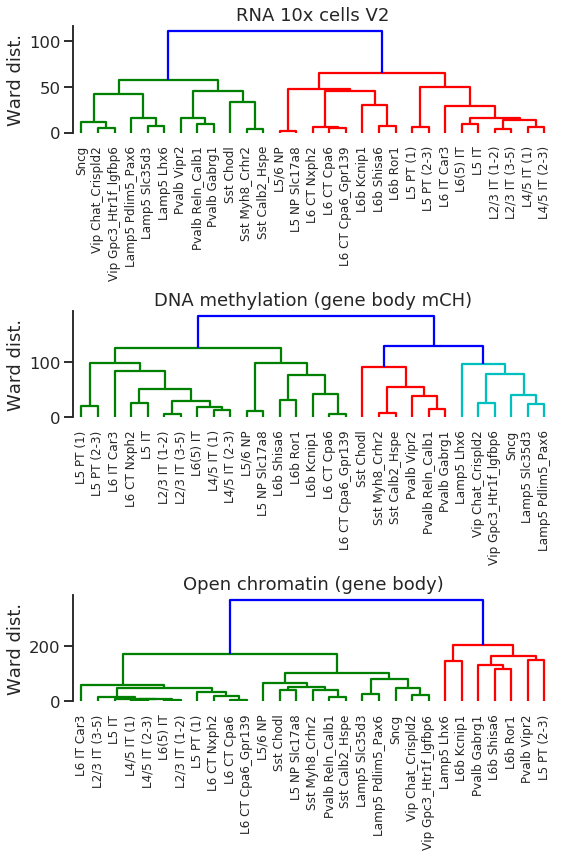

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(1*8, 3*4))
titles = ['RNA 10x cells V2', 'DNA methylation (gene body mCH)', 'Open chromatin (gene body)']
for ax, z, title in zip(axs, zs, titles):
    g = sch.dendrogram(z, ax=ax)
    ax.grid(False)
    ax.set_xticklabels(labels_from_dendro2(g), fontsize=12, rotation=90)
    ax.set_title(title)
    ax.set_ylabel('Ward dist.')
    sns.despine(ax=ax, bottom=True)
#     break
fig.tight_layout()
snmcseq_utils.savefig(fig, output_figures.format('dendrogram_mockup_L1'))
# plt.show()

In [16]:
f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
df_clst = pd.read_csv(f, sep='\t')
print(df_clst.shape)
df_clst.head()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(408885, 11)


,sample,joint_embedding_x,joint_embedding_y,modality,modality_name,single_modality_cluster,single_modality_annot,joint_cluster_round1,joint_cluster_round2,joint_cluster_round3,joint_cluster_round4
0,snmcseq_gene_2C_M_0,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1
1,snmcseq_gene_2C_M_1,-2.414973,-12.098081,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-2,4-2-1,4-2-1-1
2,snmcseq_gene_2C_M_100,-1.446751,-12.051894,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-1,4-1-1,4-1-1-1
3,snmcseq_gene_2C_M_1000,-1.901734,-13.660591,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-2,4-2-1,4-2-1-1
4,snmcseq_gene_2C_M_1001,-0.981086,-11.936621,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-1,4-1-1,4-1-1-1


In [24]:
_x = df_clst.groupby(['modality', 'joint_cluster_round2']).size().unstack().fillna(0).astype(int)
_x = _x.loc['snatac_gene'].sort_values()
_x.index = df_annot.reindex(_x.index)

In [25]:
_x

annot
Sst Chodl                    0
L6b Kcnip1                   2
L5 PT (2-3)                  8
Lamp5 Lhx6                   8
Pvalb Vipr2                 19
Pvalb Gabrg1                55
L6b Ror1                    74
L6b Shisa6                 102
Sncg                       363
Vip Gpc3_Htr1f_lgfbp6      383
L5/6 NP                    387
L5 PT (1)                  563
Lamp5 Slc35d3              707
L5 NP Slc17a8              815
Lamp5 Pdlim5_Pax6          882
Vip Chat_Crispld2          909
Sst Myh8_Crhr2             922
L6 IT Car3                 981
L6 CT Nxph2               1137
Sst Calb2_Hspe            1417
L5 IT                     2525
L6 CT Cpa6                3006
L6(5) IT                  3197
Pvalb Reln_Calb1          3347
L4/5 IT (2-3)             3896
L6 CT Cpa6_Gpr139         4216
L2/3 IT (3-5)             4560
L2/3 IT (1-2)             9426
L4/5 IT (1)              10937
Name: snatac_gene, dtype: int64

In [27]:
_x = df_clst.groupby(['modality', 'joint_cluster_round2']).size().unstack().fillna(0).astype(int)
_x = _x.loc['snmcseq_gene'].sort_values()
_x.index = df_annot.reindex(_x.index)
_x

annot
L6b Kcnip1                  5
Pvalb Vipr2                 7
Lamp5 Lhx6                  8
Pvalb Gabrg1               15
Sst Chodl                  15
L6 IT Car3                 25
L5 PT (1)                  45
L6b Shisa6                 48
L5 PT (2-3)                52
L6b Ror1                   55
Sncg                       69
L5 NP Slc17a8              88
Vip Gpc3_Htr1f_lgfbp6      94
Lamp5 Pdlim5_Pax6         105
Vip Chat_Crispld2         110
L5/6 NP                   183
Sst Myh8_Crhr2            219
Lamp5 Slc35d3             236
Sst Calb2_Hspe            243
L6 CT Nxph2               288
Pvalb Reln_Calb1          427
L6 CT Cpa6_Gpr139         623
L4/5 IT (2-3)             793
L5 IT                     836
L6 CT Cpa6                887
L2/3 IT (1-2)             893
L6(5) IT                  915
L2/3 IT (3-5)            1004
L4/5 IT (1)              1078
Name: snmcseq_gene, dtype: int64